# Homework 2
Student: Han Myrda

## 1) Describe the target
I will scrape **quotes.toscrape.com**. It's a website made for scraping practice: items (quotes) are listed across multiple pages and each item includes quote text, author and tags, which matches the assignment requirements.

## 2) Inspect with DevTools
Below you should upload two screenshots from Chrome DevTools:
1. **Network** screenshot showing the GET request to the list page and response (URL + status).  
2. **Elements** screenshot showing the HTML structure for a single item (`div.quote` with `span.text`, `small.author`, and `div.tags`).

Upload the images below (drag & drop into new markdown cells).

### Screenshot placeholder — Network request
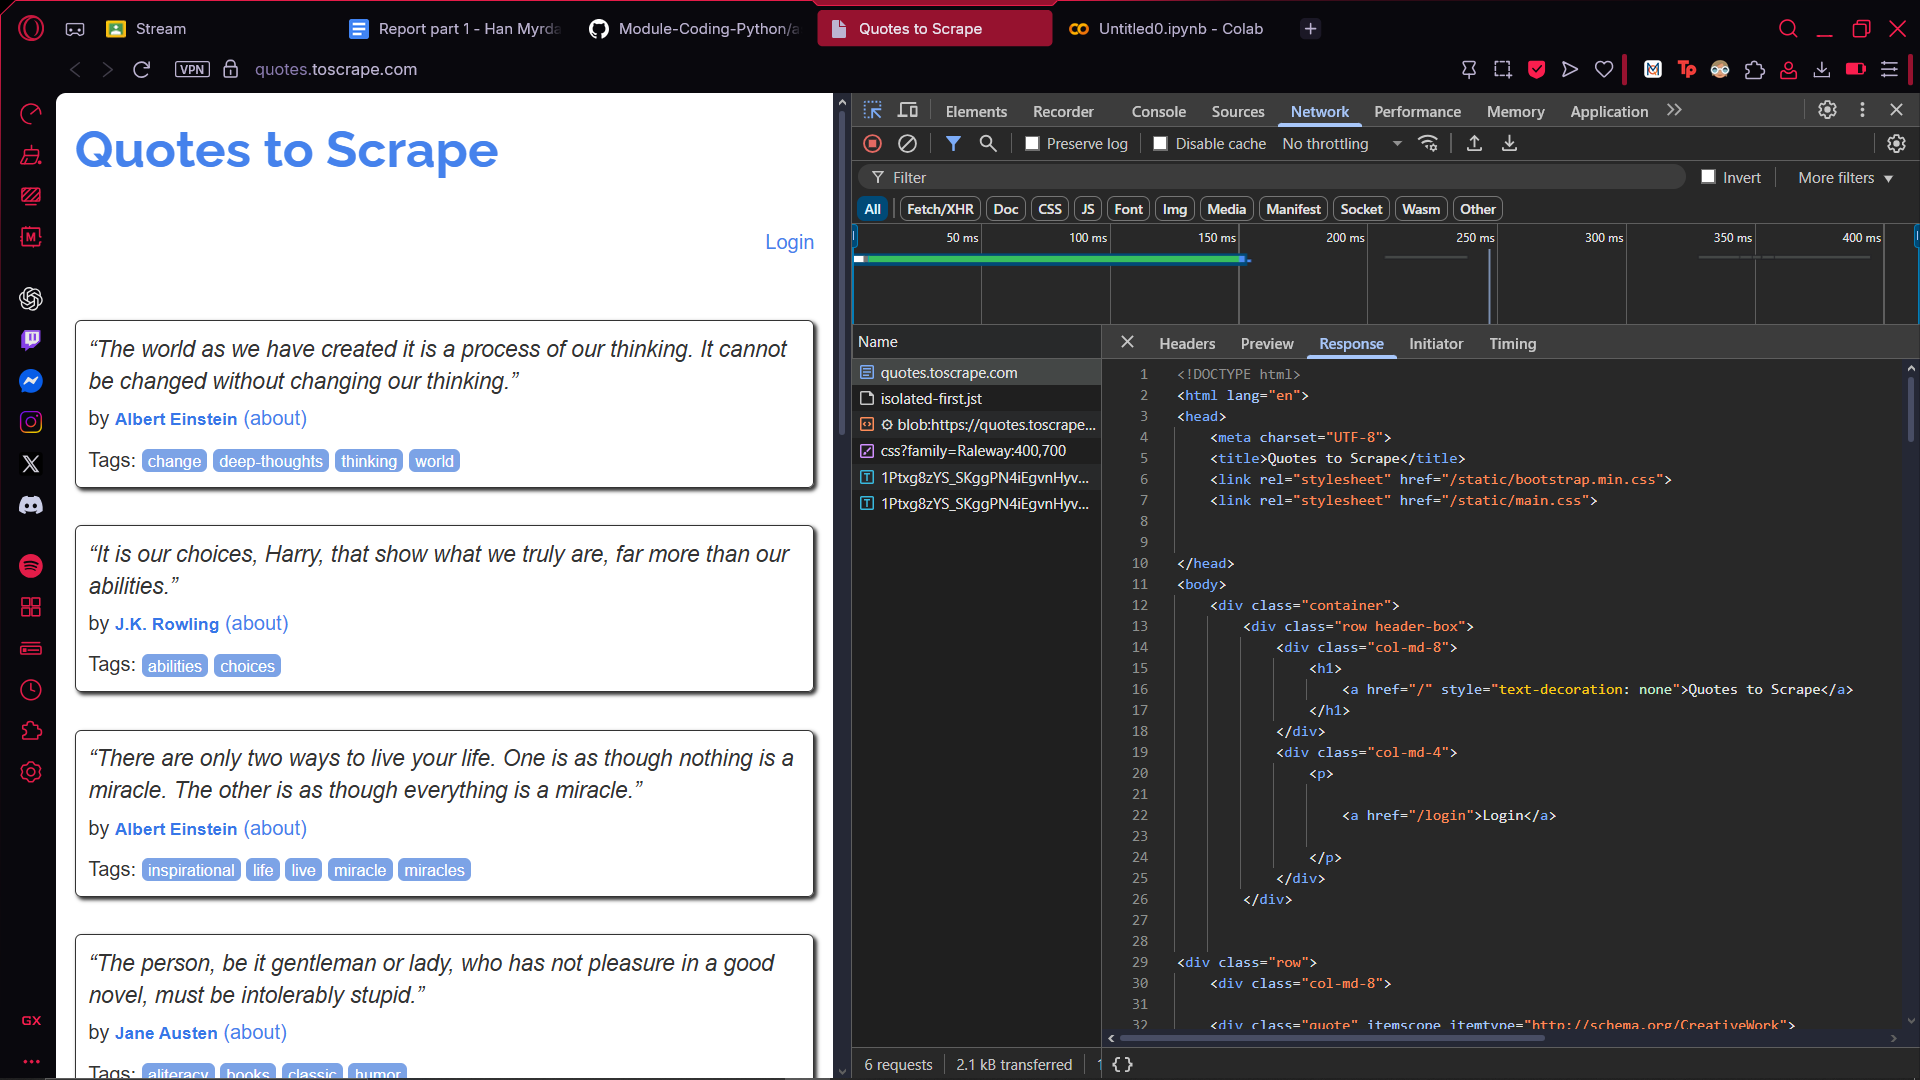

### Screenshot placeholder — HTML structure (`div.quote`)
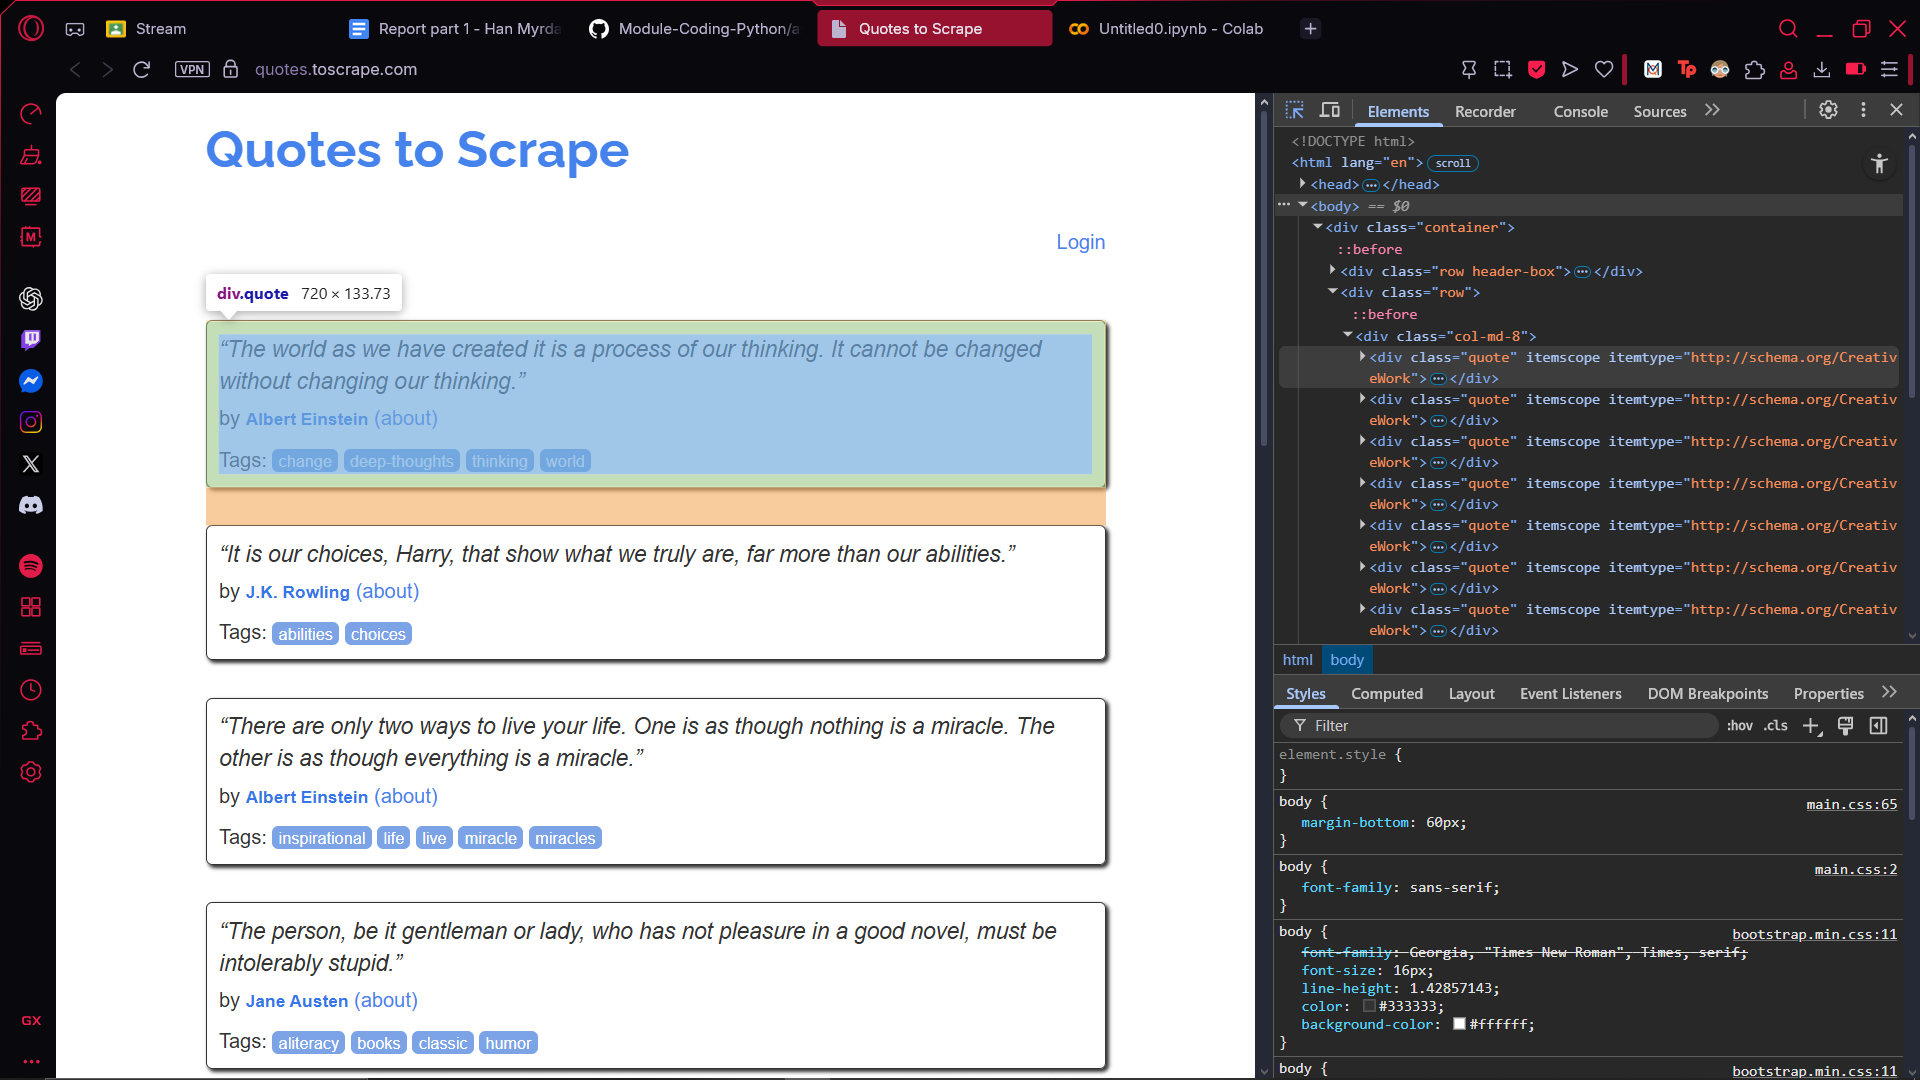

## 3) Setup: install/import libraries
Installing and importing the required libraries (`requests`, `beautifulsoup4`).

In [ ]:
!pip install -q requests beautifulsoup4
import time
from typing import Optional, Dict, List
import requests
from bs4 import BeautifulSoup
from dataclasses import dataclass
import csv
from pathlib import Path
print('Setup complete')

Setup complete


## 4) Fetcher function
Implementing the typed `fetch_html` function that returns page HTML as `str` or raises an exception on failure.

In [ ]:
def fetch_html(url: str, headers: Optional[Dict[str, str]] = None, timeout_s: float = 15.0) -> str:
    """Download HTML text from `url`.
    - Matches the assignment signature (typed).
    - Raises requests.HTTPError on bad responses.
    """
    default_headers = {
        'User-Agent': 'Homework2-scraper/1.0 (+https://github.com/yourname)'
    }
    hdrs = default_headers if headers is None else {**default_headers, **headers}
    resp = requests.get(url, headers=hdrs, timeout=timeout_s)
    resp.raise_for_status()
    return resp.text

In [ ]:
html = fetch_html('https://quotes.toscrape.com')
print(html[:500])

<!DOCTYPE html>
<html lang="en">
<head>
	<meta charset="UTF-8">
	<title>Quotes to Scrape</title>
    <link rel="stylesheet" href="/static/bootstrap.min.css">
    <link rel="stylesheet" href="/static/main.css">
    
    
</head>
<body>
    <div class="container">
        <div class="row header-box">
            <div class="col-md-8">
                <h1>
                    <a href="/" style="text-decoration: none">Quotes to Scrape</a>
                </h1>
            </div>
            <div cla


## 5) Parser
Defining a simple `@dataclass` to store each quote and a parser that extracts three fields: quote text, author, and tags.


In [ ]:
@dataclass
class QuoteItem:
    text: str
    author: str
    tags: List[str]

def parse_quotes_from_html(html: str) -> List[QuoteItem]:
    """Parse the HTML of a quotes.toscrape.com page and return a list of QuoteItem.
    Expects the structure: <div class="quote"> ... <span class="text">...</span> <small class="author">...</small> <div class="tags"> ...</div>
    """
    soup = BeautifulSoup(html, 'html.parser')
    items: List[QuoteItem] = []
    for q in soup.select('div.quote'):
        # Quote text
        text_el = q.select_one('span.text')
        quote_text = text_el.get_text(strip=True) if text_el else ''
        # Author
        auth_el = q.select_one('small.author')
        author = auth_el.get_text(strip=True) if auth_el else ''
        # Tags - multiple
        tag_els = q.select('div.tags a.tag')
        tags = [t.get_text(strip=True) for t in tag_els]
        items.append(QuoteItem(text=quote_text, author=author, tags=tags))
    return items

In [ ]:
html = fetch_html('https://quotes.toscrape.com')
print(parse_quotes_from_html(html)[:3])

[QuoteItem(text='“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”', author='Albert Einstein', tags=['change', 'deep-thoughts', 'thinking', 'world']), QuoteItem(text='“It is our choices, Harry, that show what we truly are, far more than our abilities.”', author='J.K. Rowling', tags=['abilities', 'choices']), QuoteItem(text='“There are only two ways to live your life. One is as though nothing is a miracle. The other is as though everything is a miracle.”', author='Albert Einstein', tags=['inspirational', 'life', 'live', 'miracle', 'miracles'])]


## 6) Pagination and collection loop
Following the "Next" link until I collect at least 50 items or reach a `max_pages` cap. A small delay is used between requests to be polite.

In [ ]:
def collect_quotes(start_url: str, min_items: int = 50, max_pages: int = 20, delay_s: float = 1.0) -> List[QuoteItem]:
    """Collect quotes across pages following the 'Next' link until `min_items` collected or `max_pages` reached.
    Returns a list of QuoteItem.
    """
    url = start_url
    collected: List[QuoteItem] = []
    page = 0
    while len(collected) < min_items and page < max_pages and url:
        page += 1
        print(f'Fetching page {page}: {url}')
        try:
            html = fetch_html(url)
        except Exception as e:
            print('Fetch failed:', e)
            break
        items = parse_quotes_from_html(html)
        print(f'  Parsed {len(items)} items')
        collected.extend(items)
        # find next page link
        soup = BeautifulSoup(html, 'html.parser')
        next_link = soup.select_one('li.next a')
        if next_link and next_link.get('href'):
            url = requests.compat.urljoin(url, next_link['href'])
        else:
            url = None
        time.sleep(delay_s)  # politeness
    return collected

In [ ]:
quotes = collect_quotes('https://quotes.toscrape.com', min_items=50)
print('Total collected:', len(quotes))

Fetching page 1: https://quotes.toscrape.com
  Parsed 10 items
Fetching page 2: https://quotes.toscrape.com/page/2/
  Parsed 10 items
Fetching page 3: https://quotes.toscrape.com/page/3/
  Parsed 10 items
Fetching page 4: https://quotes.toscrape.com/page/4/
  Parsed 10 items
Fetching page 5: https://quotes.toscrape.com/page/5/
  Parsed 10 items
Total collected: 50


## 7) CSV export
Saving collected items to a semicolon-separated CSV. Tags are joined with commas in the third field.


In [ ]:
def save_quotes_to_csv(items: List[QuoteItem], path: str) -> None:
    """Save list of QuoteItem to CSV with ';' separator. Tags are joined by ','."""
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    with open(path, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f, delimiter=';')
        # header
        writer.writerow(['text', 'author', 'tags'])
        for it in items:
            # Ensuring fields are plain strings; join tags with commas
            writer.writerow([it.text, it.author, ','.join(it.tags)])
    print(f'Saved {len(items)} items to {path}')


In [ ]:
save_quotes_to_csv(quotes, 'assignments/homework 2/Han Myrda/quotes.csv')

Saved 50 items to assignments/homework 2/Han Myrda/quotes.csv


## 8) Politeness & caps
- A `time.sleep` call (default 1 second) is used between page requests to be polite.  
- `max_pages` default is 20 to avoid accidental infinite crawling.  
- If a request fails, the loop prints an error and stops; you can re-run later from the last collected page.

## 10) Documentation — what worked, what broke, how I handled it
Example notes (edit to match your actual run):
- **What worked:** The fetcher function successfully downloaded HTML and the parser extracted quote text, author and tags. Pagination following `li.next a` reliably moved through pages until 50 items were collected.  
- **What broke / edge cases:** Occasionally the connection timed out on a single page (requests.exceptions.ReadTimeout). I handled this by stopping the loop and re-running after a short wait.  
- **How I handled it:** I implemented `resp.raise_for_status()` in `fetch_html` to detect HTTP errors and used a polite `time.sleep(1)` between requests; I also set `max_pages=20` to avoid long crawls.  

Replace these example notes with your final observations after you run the notebook.